# Description

#### Project  <span style="color:blue">NLP for divorce court decision documents</span> 

#### Content  <span style="color:blue">Classifying text documents</span> 

#### Notebook Language  <span style="color:blue">python</span> 


In [14]:
import sys
sys.path.insert(0, "/usr/local/lib/python3.5/dist-packages")
import re #for string operations
import pandas as pd #for dataframes
from gensim.models import Word2Vec #Word2Vec
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt

ImportError: C extension: No module named tslib not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext --inplace --force' to build the C extensions first.

In [13]:
import pandas as pd

ImportError: C extension: No module named tslib not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext --inplace --force' to build the C extensions first.

In [11]:
from kodex_nlp import read_files, get_stemmer #user functions

ImportError: No module named kodex_nlp

# <span style="color:blue">1</span>  Read and Stem .pdf Documents from Path

In [3]:
stemmer = "turkishstemmer" # turkishstemmer, snowball, zemberek

bozma = read_files("yargıtay_kararları/bozma/", stemmer = stemmer)
onama = read_files("yargıtay_kararları/onam-detay/", stemmer = stemmer)
kismen = read_files("yargıtay_kararları/kısmen/", stemmer = stemmer)

all_docs = bozma + onama + kismen

### Ground Truth Values:

In [4]:
Y = np.concatenate((
    np.ones(len(bozma))*0,
    np.ones(len(onama))*1,
    np.ones(len(kismen))*2))

# <span style="color:blue">2</span> TF $\times$ IDF

## Split Dataset

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    all_docs, Y, test_size=0.3, random_state=108)

n_train = len(y_train)
n_val = len(y_val)

## Term Freq Matrices

In [6]:
cnt_vec = CountVectorizer()

transformed_data = cnt_vec.fit_transform(X_train+X_val)
TF = transformed_data.toarray()
TF_train = TF[:n_train,:] # Term freq for train
TF_val = TF[n_train:,:] # Term freq for validation

## IDF

In [7]:
def idf(word_freqs):
    N = len(word_freqs)
    n = np.sum(word_freqs > 1/5000)
    return np.log10(N/(n+1))

In [8]:
IDF_train = np.apply_along_axis(idf, 0, TF_train)
TF_IDF_train = np.multiply(TF_train, IDF_train)

In [9]:
TF_IDF_val = np.zeros((TF_val.shape))

In [10]:
def extract_tfidf_val(current_TF, TF = TF_IDF_train):
    TF = np.row_stack((TF, current_TF)  ) 
    IDF = np.apply_along_axis(idf, 0, TF)
    return np.multiply(current_TF, IDF)

In [11]:
TF_IDF_val = np.apply_along_axis(extract_tfidf_val, 1, TF_val)

In [12]:
TF_IDF_val.shape

(129, 2372)

# <span style="color:blue">3</span> SVD

In [13]:
m = 75
svd = TruncatedSVD(n_components=m, random_state=1)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(TF_IDF_train)

In [14]:
X_val_lsa = lsa.transform(TF_IDF_val)

# <span style="color:blue">4</span> Classification: kNN

In [15]:
knn_lsa = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric='cosine', weights='distance')
knn_lsa.fit(X_train_lsa, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='cosine',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [16]:
p = knn_lsa.predict(X_val_lsa)

In [17]:
bozma = 0
onama = 0
kismen = 0

for i in range(0,len(p)):
    if p[i] == y_val[i]:
        
        if p[i] == 0:
            bozma += 1
        if p[i] == 1:
            onama += 1
        if p[i] == 2:
            kismen += 1

numRight = bozma+onama+kismen

print("Bozma:(%d / %d) correct - %.2f%%" % (bozma, np.sum(y_val==0), float(bozma) / float(np.sum(y_val==0)) * 100.0))
print("Onama:(%d / %d) correct - %.2f%%" % (onama, np.sum(y_val==1), float(onama) / float(np.sum(y_val==1)) * 100.0))
print("Kısmen:(%d / %d) correct - %.2f%%" % (kismen, np.sum(y_val==2), float(kismen) / float(np.sum(y_val==2)) * 100.0))
print("Overall:(%d / %d) correct - %.2f%%" % (numRight, len(y_val), float(numRight) / float(len(y_val)) * 100.0))

Bozma:(30 / 37) correct - 81.08%
Onama:(52 / 55) correct - 94.55%
Kısmen:(34 / 37) correct - 91.89%
Overall:(116 / 129) correct - 89.92%


## Visualization

In [18]:
colo = y_train.astype("str")
colo[colo == '0.0'] = 'b'
colo[colo == '1.0'] = 'g'
colo[colo == '2.0'] = 'r'

printing only first 2 of 75 components


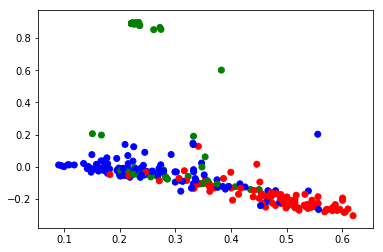

blue = bozma
green = onama
red = kismen


In [19]:
print("printing only first 2 of "+str(m)+" components")
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c = colo, cmap=None)
plt.show()
print("blue = bozma\ngreen = onama\nred = kismen")

# <span style="color:blue">5</span> Classification: Neural Network

In [20]:
from keras.models import Sequential

from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization

from keras.utils import np_utils

from keras.optimizers import adam

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, History

import keras

/home/enes/Documents/DLwK/env_DLwK/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
m = 200
svd = TruncatedSVD(n_components=m, random_state=1)
lsa = make_pipeline(svd, Normalizer(copy=False))
NN_X_train = lsa.fit_transform(TF_IDF_train)
NN_X_val = lsa.transform(TF_IDF_val)

In [22]:
num_classes = 3
NN_y_train = np_utils.to_categorical(y_train, num_classes)
NN_y_val = np_utils.to_categorical(y_val, num_classes)

In [23]:
def model_X():
    #modeling
    model = Sequential()

    model.add(Dense(128, input_shape = NN_X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
        
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = keras.optimizers.adam()

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

   
    return(model)

In [24]:
model=model_X()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               25728     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
__________

In [25]:
y_train.shape

(300,)

In [26]:
temp = model.fit(NN_X_train, NN_y_train,
                    batch_size=16,
                    epochs=200,
                    verbose=1,
                    validation_data=(NN_X_val, NN_y_val))

Train on 300 samples, validate on 129 samples
Epoch 1/200
300/300 [==============================] - 0s 1ms/step - loss: 1.4214 - acc: 0.3867 - val_loss: 1.0682 - val_acc: 0.5039
Epoch 2/200
300/300 [==============================] - 0s 273us/step - loss: 1.2387 - acc: 0.4300 - val_loss: 1.0465 - val_acc: 0.4419
Epoch 3/200
300/300 [==============================] - 0s 289us/step - loss: 1.1539 - acc: 0.4467 - val_loss: 1.0281 - val_acc: 0.4806
Epoch 4/200
300/300 [==============================] - 0s 372us/step - loss: 0.9594 - acc: 0.5500 - val_loss: 1.0056 - val_acc: 0.5736
Epoch 5/200
300/300 [==============================] - 0s 364us/step - loss: 0.9605 - acc: 0.5400 - val_loss: 0.9826 - val_acc: 0.6279
Epoch 6/200
300/300 [==============================] - 0s 310us/step - loss: 0.8342 - acc: 0.6367 - val_loss: 0.9567 - val_acc: 0.6434
Epoch 7/200
300/300 [==============================] - 0s 341us/step - loss: 0.8151 - acc: 0.6200 - val_loss: 0.9297 - val_acc: 0.7287
Epoch 8/200

Epoch 61/200
300/300 [==============================] - 0s 291us/step - loss: 0.1075 - acc: 0.9633 - val_loss: 0.1851 - val_acc: 0.9302
Epoch 62/200
300/300 [==============================] - 0s 301us/step - loss: 0.1138 - acc: 0.9700 - val_loss: 0.1844 - val_acc: 0.9302
Epoch 63/200
300/300 [==============================] - 0s 290us/step - loss: 0.1559 - acc: 0.9500 - val_loss: 0.1972 - val_acc: 0.9457
Epoch 64/200
300/300 [==============================] - 0s 302us/step - loss: 0.0858 - acc: 0.9733 - val_loss: 0.1991 - val_acc: 0.9457
Epoch 65/200
300/300 [==============================] - 0s 282us/step - loss: 0.0857 - acc: 0.9900 - val_loss: 0.1985 - val_acc: 0.9457
Epoch 66/200
300/300 [==============================] - 0s 295us/step - loss: 0.0766 - acc: 0.9767 - val_loss: 0.1924 - val_acc: 0.9457
Epoch 67/200
300/300 [==============================] - 0s 316us/step - loss: 0.0461 - acc: 0.9967 - val_loss: 0.1905 - val_acc: 0.9457
Epoch 68/200
300/300 [==========================

300/300 [==============================] - 0s 352us/step - loss: 0.0510 - acc: 0.9900 - val_loss: 0.2495 - val_acc: 0.9380
Epoch 122/200
300/300 [==============================] - 0s 281us/step - loss: 0.0346 - acc: 0.9967 - val_loss: 0.2488 - val_acc: 0.9380
Epoch 123/200
300/300 [==============================] - 0s 286us/step - loss: 0.0470 - acc: 0.9900 - val_loss: 0.2568 - val_acc: 0.9457
Epoch 124/200
300/300 [==============================] - 0s 282us/step - loss: 0.0499 - acc: 0.9900 - val_loss: 0.2632 - val_acc: 0.9457
Epoch 125/200
300/300 [==============================] - 0s 286us/step - loss: 0.0549 - acc: 0.9933 - val_loss: 0.2524 - val_acc: 0.9380
Epoch 126/200
300/300 [==============================] - 0s 272us/step - loss: 0.0279 - acc: 0.9933 - val_loss: 0.2434 - val_acc: 0.9457
Epoch 127/200
300/300 [==============================] - 0s 283us/step - loss: 0.0217 - acc: 0.9933 - val_loss: 0.2478 - val_acc: 0.9457
Epoch 128/200
300/300 [==============================] 

Epoch 181/200
300/300 [==============================] - 0s 268us/step - loss: 0.0168 - acc: 0.9967 - val_loss: 0.3065 - val_acc: 0.9302
Epoch 182/200
300/300 [==============================] - 0s 276us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.3094 - val_acc: 0.9380
Epoch 183/200
300/300 [==============================] - 0s 279us/step - loss: 0.0150 - acc: 0.9933 - val_loss: 0.3171 - val_acc: 0.9380
Epoch 184/200
300/300 [==============================] - 0s 275us/step - loss: 0.0172 - acc: 0.9967 - val_loss: 0.3195 - val_acc: 0.9380
Epoch 185/200
300/300 [==============================] - 0s 309us/step - loss: 0.0721 - acc: 0.9800 - val_loss: 0.3115 - val_acc: 0.9302
Epoch 186/200
300/300 [==============================] - 0s 343us/step - loss: 0.0198 - acc: 0.9900 - val_loss: 0.3055 - val_acc: 0.9302
Epoch 187/200
300/300 [==============================] - 0s 381us/step - loss: 0.0338 - acc: 0.9867 - val_loss: 0.3065 - val_acc: 0.9380
Epoch 188/200
300/300 [==================

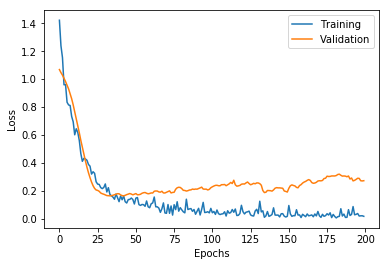

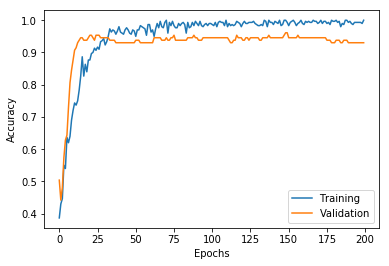

In [27]:
%matplotlib inline

curr_loss=temp.history['loss']
curr_val_loss=temp.history['val_loss']
curr_acc=temp.history['acc']
curr_val_acc=temp.history['val_acc']   

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(curr_loss)
plt.plot(curr_val_loss)
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(curr_acc)
plt.plot(curr_val_acc)
plt.legend(['Training', 'Validation'], loc='lower right')